# Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data import and cleaning:

In [2]:
us_data = pd.read_csv("data/nextstrain_ncov_north-america_metadata.tsv", delimiter='\t', error_bad_lines=False) # Reads in the nextrain dataset
us_data = us_data[us_data['Country'] == 'USA']  # select only the US relevent data
strain_per_st = pd.read_csv("data/Total Sequences Submitted Publicly Available_.csv")  # reads in the total publically seqenced genome data from CDC
ny_times = pd.read_csv("data/ny_times_us_states.csv")  # reads in total cases and deaths from nytimes
st_abv = pd.read_excel("data/state_abreviations.xlsx", header=None)  # reads in dataframe with state names and abreviations
case_by_var = pd.read_csv("data/Cases of Variants of Concern in the United States.csv")  # reads in the number of cases of consern from CDC
us_population = pd.read_csv('data/ACSDP1Y2019.DP05_data_with_overlays_2021-03-25T141408.csv')  #  Reads in US population from the cencus bureau
#########################################################################################################
# data manipulation, spliting combining and curating custom dataframes for analysis
#########################################################################################################
# this block manipulates the nytimes dataset to output cases and deaths by state
state_cases = {i:0 for i in ny_times['state'].unique()}  # creates a dictionary of states and cases with 0 as a placeholder value
state_deaths = {i:0 for i in ny_times['state'].unique()}  # creates a dictionary of states and cases with 0 as a placeholder value
for i in range(1,len(ny_times)):  # iterate through ny_times data frame
    state_cases[ny_times['state'][i]] = ny_times['cases'][i]  # add most recent value to each state in dictionary
    state_deaths[ny_times['state'][i]] = ny_times['deaths'][i]  # add most recent value to each state in dictionary
state_cases = pd.DataFrame.from_dict(state_cases, orient = 'index' , columns = ['total_cases'])  # create a df object from dic
state_deaths = pd.DataFrame.from_dict(state_deaths, orient = 'index', columns = ['total_deaths'])  # create a df object from dic
state_totals = state_cases.merge(state_deaths, left_index=True, right_index=True)  # merge data frames to a single df
state_totals.drop('Guam', axis = 0, inplace = True)  # drop guam (not standard in other df)
state_totals.rename(index = {'District of Columbia' : 'Washington DC'}, inplace = True)  # rename washinton DC for consistency

# this block counts the number of instances for each state and initalizes our main summary dataframe: 'totals'
nx_clade_nums = pd.DataFrame(us_data[us_data['Country'] == 'USA']['Admin Division'].value_counts())  # create dataframe with number of clades per state
nx_clade_nums.drop('Grand Princess', axis = 0, inplace = True)  # drop the grand pricness for consistency  # todo: may not need to drop, this might happen in the merge
nx_clade_nums.rename(columns={"Admin Division": "num_clades"}, inplace = True)  # rename column
totals = state_totals.merge(nx_clade_nums, left_index=True, right_index=True) # merge dataframes on the axis into a summary dataframe called 'totals'

# this block adds the number of each clade observed in each state
strain_by_state = us_data.groupby(['Admin Division', 'Clade']).count().unstack()['Strain'].fillna(0)  # count the number of clades by state
totals = totals.merge(strain_by_state, left_index=True, right_index=True)  # merge number of strains per state into 'totals'

# this block gathers the number of s1 mutations per state and adds it to the 'totals' dataframe
s1_muts = us_data.groupby(['Admin Division', 'S1 mutations']).count().unstack()['Strain'].fillna(0) # counts the instances of each number of mutations
s1_muts['total_s1_mutations'] = s1_muts[1.0] + (s1_muts[2.0] * 2)+ (s1_muts[3.0] * 3) + (s1_muts[4.0] * 4) + (s1_muts[5.0] * 5) + (s1_muts[6.0] * 6) + (s1_muts[7.0] * 7)+ (s1_muts[8.0] * 8) #sums the total number of mutations
totals = totals.merge(s1_muts, left_index=True, right_index=True) # adds the number of total mutations to totals

# this block adds the population of each state to the main datafram 'totals'
pop = us_population[['NAME', 'DP05_0001E']] # selects population data from imported dataset
pop = pop.replace("District of Columbia", "Washington DC") # replace name to avoid dropping
pop.set_index('NAME', inplace = True) # set index to name of state
totals = totals.merge(pop, left_index = True, right_index=True) # merge population data into main dataframe 'totals'
totals['total_pop_2019'] = totals['DP05_0001E'].astype(float) # create a float representation of the population for mathematical operations
totals['cases_per_cap'] = totals['total_cases'] / totals['total_pop_2019']  # this adds a 'cases per capita' column to the dataframe

# this block uses a state abreviation dataframe with state and its 2 letter abreviation to merge dataframes
st_abv['State'] = st_abv[0].apply(lambda x: x.title()) # corrects capitalization for each state name
st_abv.rename(columns = {1:'abv'}, inplace = True) # renames column to 'abv' for abreviation
st_abv.drop(0, axis = 1, inplace = True) # drops irrelevent data
st_abv = st_abv.set_index('abv') # sets the index to state abreviations
strain_per_st = strain_per_st.set_index('State')  # sets the index of an imported dataset to 'state' wich is represented by 2 letter abreviations
temp = st_abv.merge(strain_per_st, left_index=True, right_index=True) # creates a temporary dataframe to merge the abreviations dataframe, and the number of sequences per state dataframe
temp = temp.set_index('State') # sets the index of the temporary dataframe to 'state' to match that of the main dataframe 'totals'
temp.rename(index={'Rhode\xa0Island':'Rhode Island'}, inplace=True) # needed to fix encoding issue
totals = totals.merge(temp, left_index=True, right_index=True) # appends the temporary dataframe to 'totals'

# this block adds mutations per observation to the main dataframe
totals['s1 mutations per observation'] = totals['total_s1_mutations'] / totals['Total SARS-CoV-2 Sequences']

totals.drop(['num_clades', 'DP05_0001E'], axis = 1, inplace = True)

C:\Users\David.Ristau\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 602: expected 24 fields, saw 34\nSkipping line 1398: expected 24 fields, saw 34\nSkipping line 1614: expected 24 fields, saw 34\nSkipping line 2973: expected 24 fields, saw 27\n'


# Data Visualization:

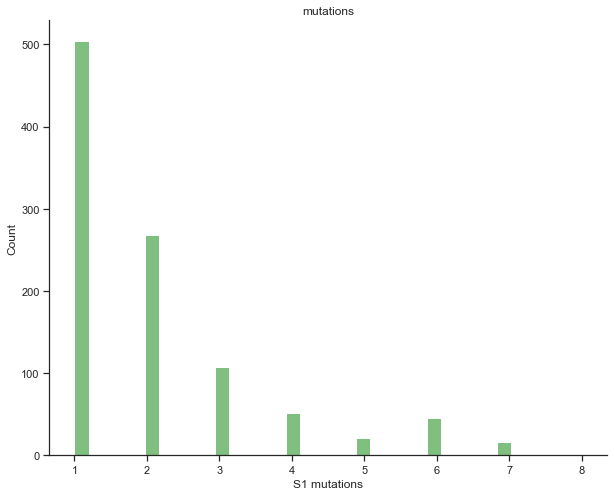

In [3]:
fig = plt.figure(figsize = (10,8))
sns.set_theme(style = 'ticks')
ax = sns.histplot(x ='S1 mutations', data = us_data, color = 'green', alpha = 0.5)
sns.despine(fig)
ax.set_title('mutations')
pass

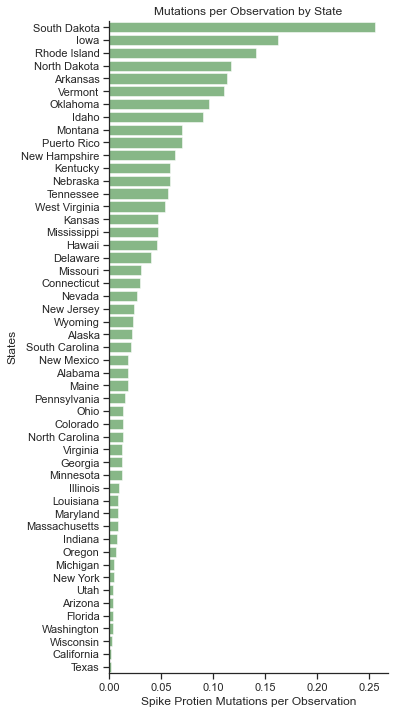

In [4]:
totals = totals.sort_values(by = 's1 mutations per observation', ascending = False)
fig = plt.figure(figsize = (5,12))
sns.set_theme(style = 'ticks')
ax = sns.barplot(x = totals['s1 mutations per observation'], y = totals.index ,color = 'green', alpha = 0.5)
sns.despine(fig)
ax.set_title('Mutations per Observation by State')
ax.set_xlabel('Spike Protien Mutations per Observation')
ax.set_ylabel('States')
pass

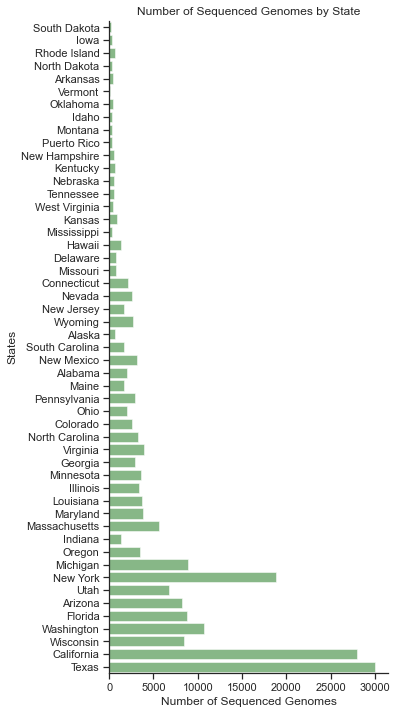

In [5]:
totals = totals.sort_values(by = 's1 mutations per observation', ascending = False)
fig = plt.figure(figsize = (5,12))
sns.set_theme(style = 'ticks')
ax = sns.barplot(x = totals['Total SARS-CoV-2 Sequences'], y = totals.index ,color = 'green', alpha = 0.5)
sns.despine(fig)
ax.set_title('Number of Sequenced Genomes by State')
ax.set_xlabel('Number of Sequenced Genomes')
ax.set_ylabel('States')
pass

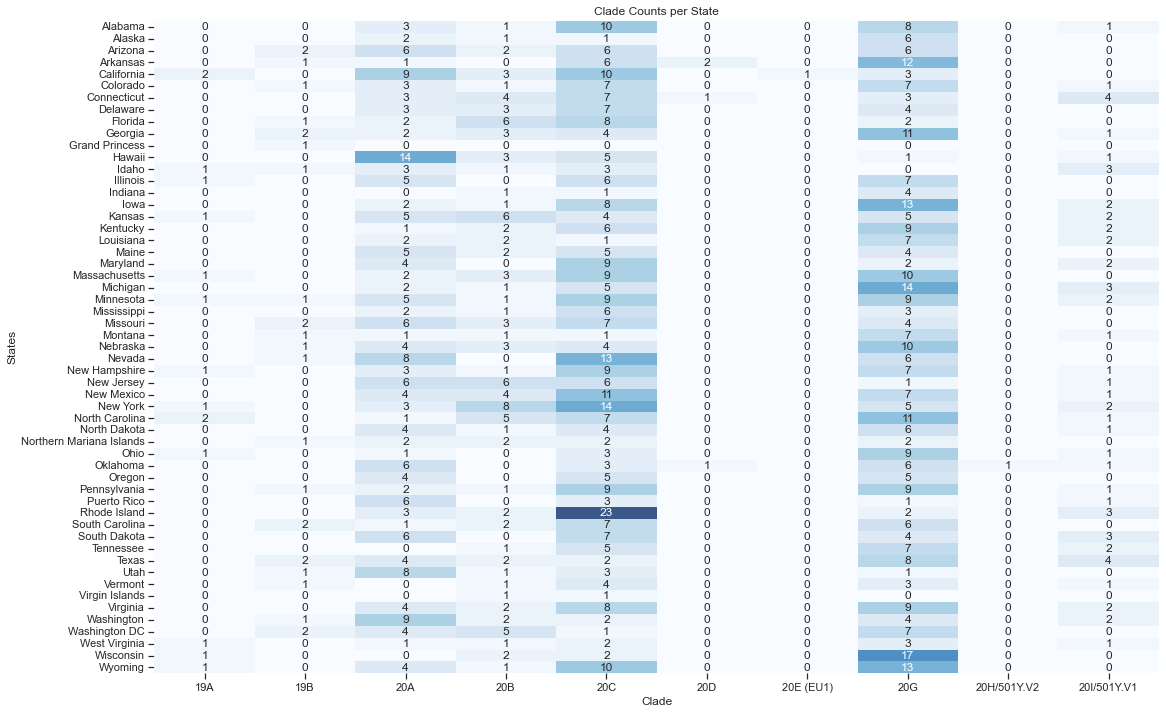

In [6]:
fig = plt.figure(figsize = (18,12))
ax = sns.heatmap(strain_by_state, cmap = 'Blues', alpha = 0.8, annot = True, cbar = False,)
ax.set_ylabel('States')
ax.set_title('Clade Counts per State')
pass

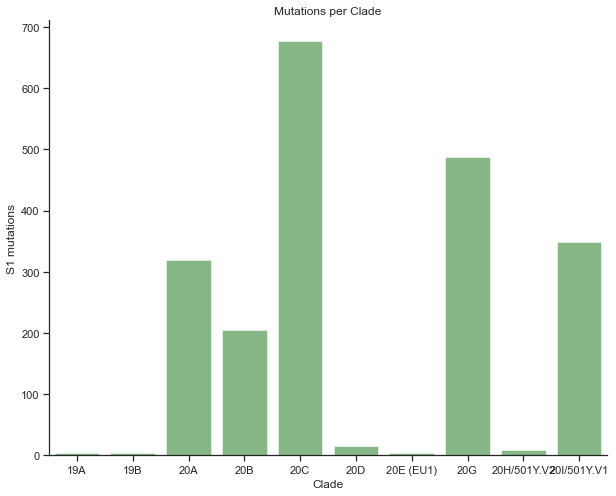

In [7]:
muts_per_clade = pd.DataFrame(us_data.groupby('Clade').sum()['S1 mutations'])
fig = plt.figure(figsize = (10,8))
sns.set_theme(style = 'ticks')
ax = sns.barplot(x = muts_per_clade.index, y = muts_per_clade['S1 mutations'],color = 'green', alpha = 0.5)
sns.despine(fig)
ax.set_title('Mutations per Clade')
pass

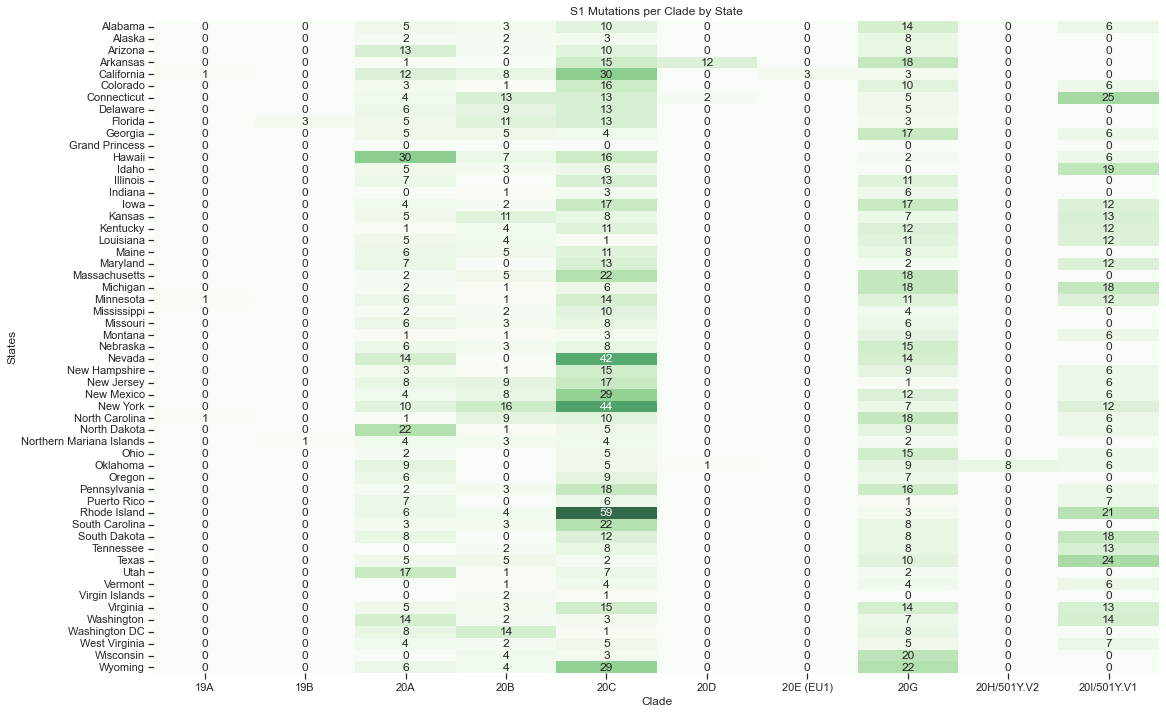

In [8]:
new_df = us_data.pivot_table(values = 'S1 mutations', index = 'Admin Division', columns='Clade', aggfunc='sum').fillna(0)
fig = plt.figure(figsize = (18,12))
ax = sns.heatmap(new_df, cmap = 'Greens', alpha = 0.8, annot = True, cbar = False,)
ax.set_ylabel('States')
ax.set_title('S1 Mutations per Clade by State')
pass

Text(0.5, 1.0, 'Top 10 States With Most B.1.1.7 Variant Cases versus P.1 and B.1.1.7 Variant Cases')

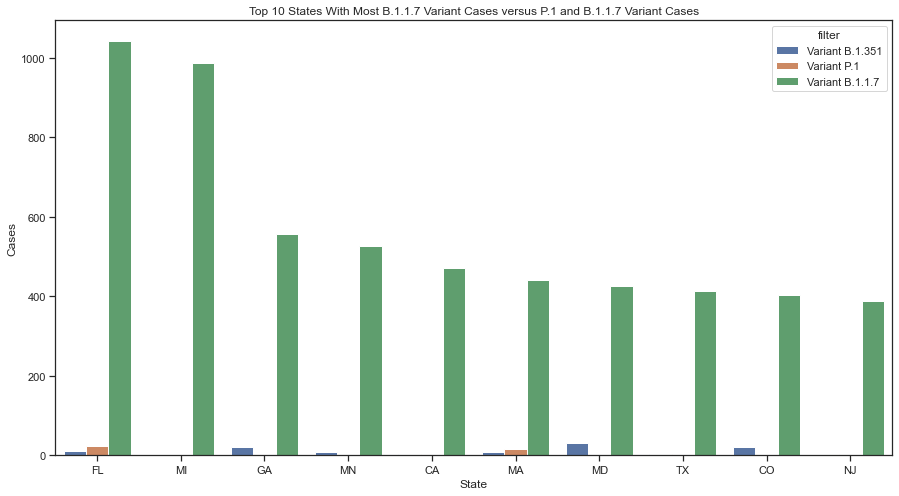

In [9]:
sort_b117_case_by_var = case_by_var.sort_values(by = 'B.1.1.7 Variant ', ascending= False)

fig, ax = plt.subplots(figsize=(15, 8))
sns.set_color_codes("pastel")
sns.barplot(y=sort_b117_case_by_var["Cases"], x=sort_b117_case_by_var['State'][:30], hue = sort_b117_case_by_var['filter']).set_title('Top 10 States With Most B.1.1.7 Variant Cases versus P.1 and B.1.1.7 Variant Cases')

Text(0.5, 1.0, 'Top 10 States With Most P.1 Variant Cases')

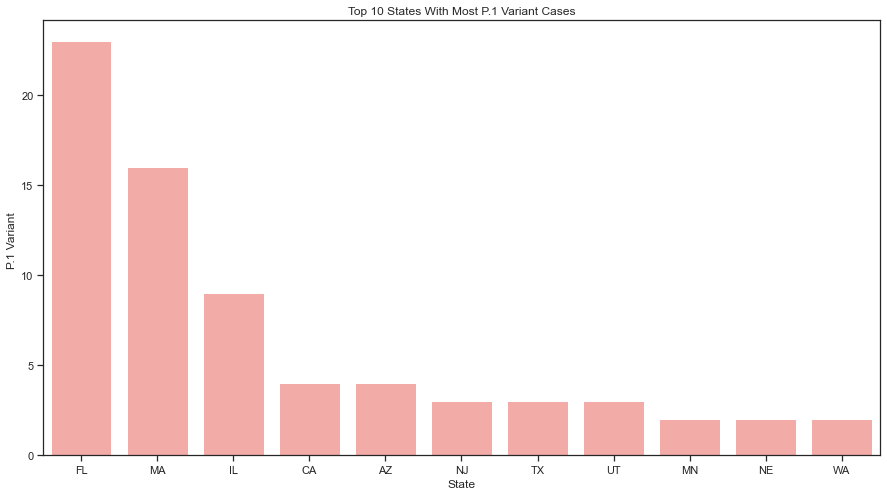

In [10]:
sort_p1_case_by_var = case_by_var.sort_values(by = 'P.1 Variant ', ascending= False)
plt.subplots(figsize=(15, 8))
sns.set_color_codes("pastel")
sns.barplot(y=sort_p1_case_by_var["P.1 Variant "], x=sort_p1_case_by_var["State"][:30], color="r").set_title('Top 10 States With Most P.1 Variant Cases')

Text(0.5, 1.0, 'Top 10 States With Most B.1.1.7 Variant Cases')

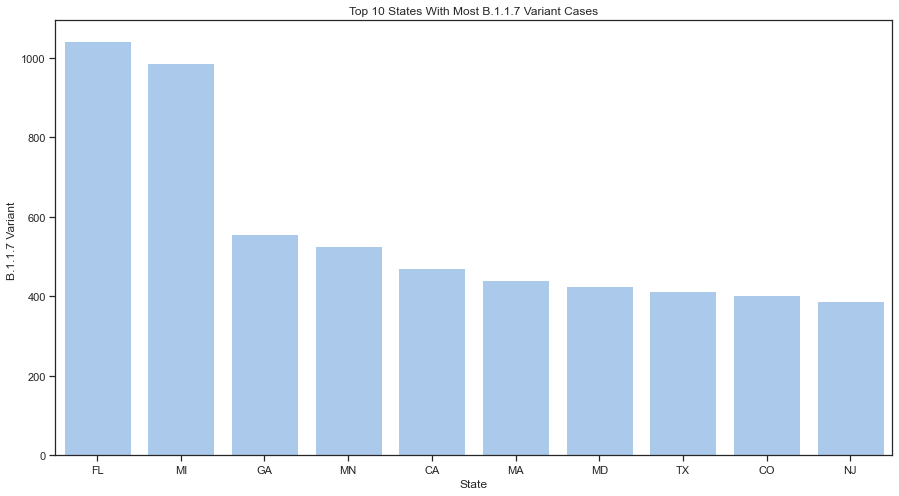

In [11]:
sort_b117_case_by_var = case_by_var.sort_values(by = 'B.1.1.7 Variant ', ascending= False)
plt.subplots(figsize=(15, 8))
sns.set_color_codes("pastel")
sns.barplot(y=sort_b117_case_by_var["B.1.1.7 Variant "], x=sort_b117_case_by_var["State"][:30], color="b").set_title('Top 10 States With Most B.1.1.7 Variant Cases')

Text(0.5, 1.0, 'Top 10 States With Most B.1.351 Variant Cases')

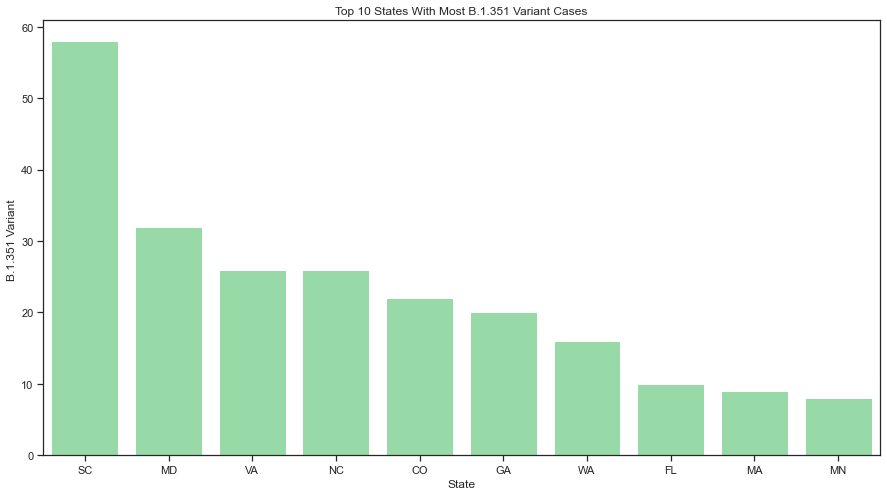

In [12]:
sort_b1351_case_by_var = case_by_var.sort_values(by = 'B.1.351 Variant ', ascending= False)
plt.subplots(figsize=(15, 8))
sns.set_color_codes("pastel")
sns.barplot(y=sort_b1351_case_by_var["B.1.351 Variant "], x=sort_b1351_case_by_var["State"][:30], color="g").set_title('Top 10 States With Most B.1.351 Variant Cases')

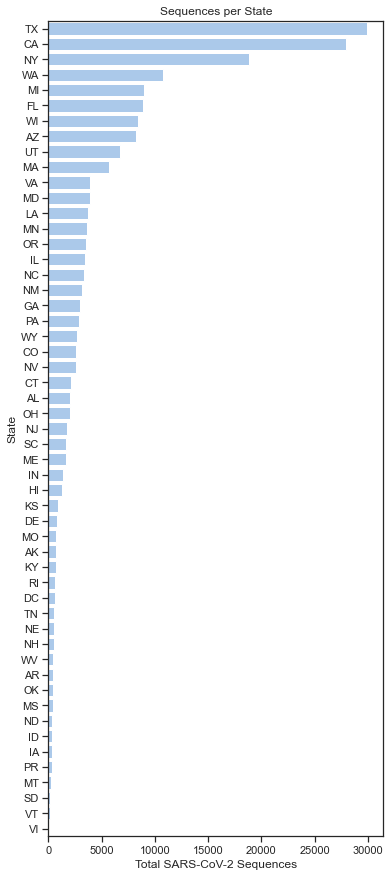

In [13]:
sorted_data = strain_per_st.sort_values(by = 'Total SARS-CoV-2 Sequences', ascending= False)
plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
sns.barplot(y=sorted_data.index, x="Total SARS-CoV-2 Sequences", data=sorted_data, label="Total", color="b").set_title('Sequences per State')
pass

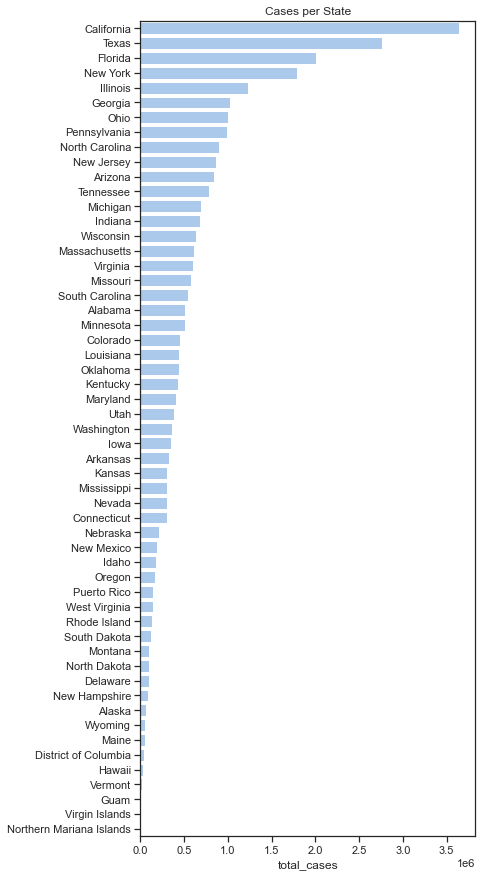

In [14]:
state_cases.sort_values(by ='total_cases', ascending= False, inplace = True)
plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
sns.barplot(y=state_cases.index, x=state_cases['total_cases'], label="Total", color="b").set_title('Cases per State')
pass

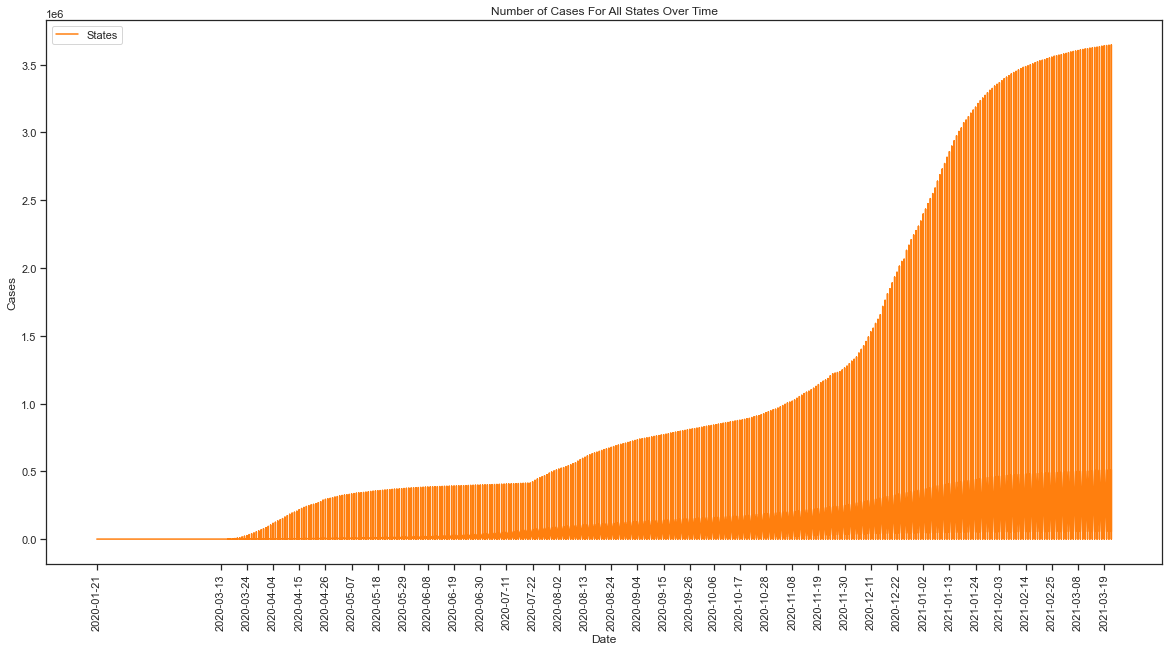

In [15]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 10))

# Specify how our lines should look
ax.plot(ny_times.date, ny_times.cases, color='tab:orange', label='States')

plt.xticks(ny_times.date[::600], ny_times.date.values[::600], rotation=90)

# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title('Number of Cases For All States Over Time')
ax.grid(False)
ax.legend(loc='upper left');

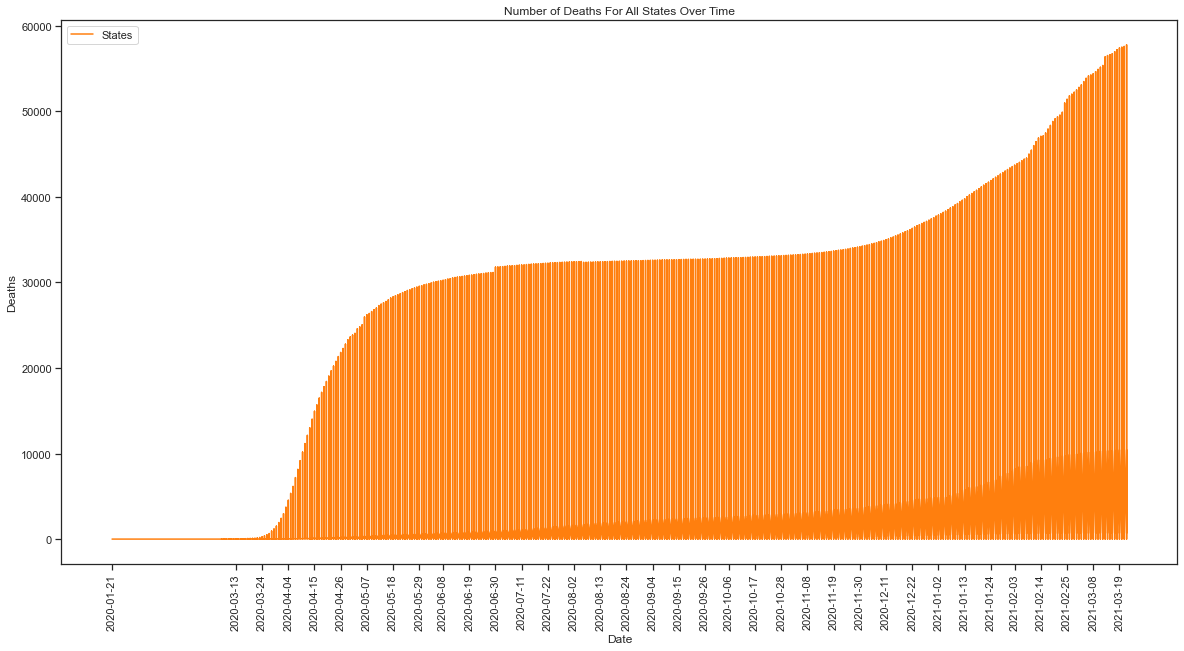

In [16]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 10))

# Specify how our lines should look
ax.plot(ny_times.date, ny_times.deaths, color='tab:orange', label='States')

plt.xticks(ny_times.date[::600], ny_times.date.values[::600], rotation=90)

# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_title('Number of Deaths For All States Over Time')
ax.grid(False)
ax.legend(loc='upper left');

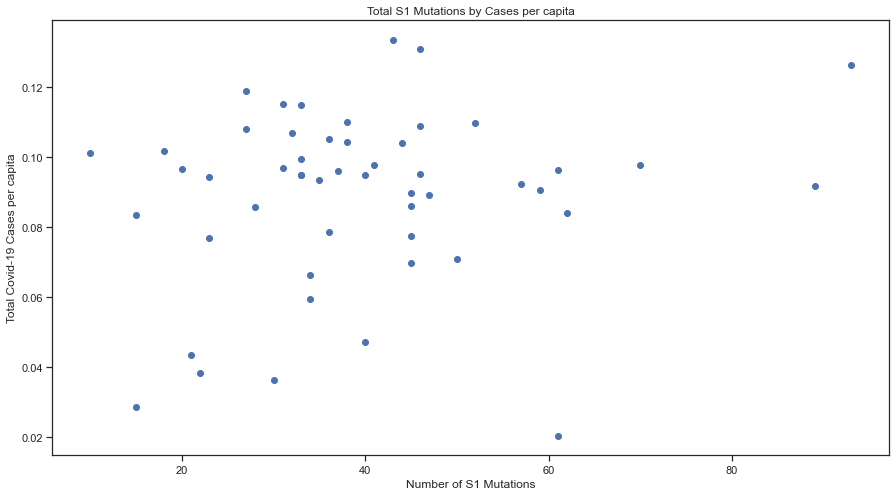

In [17]:
# scatter plot of s1 mutations on x-axis, cases per capita on y
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax = plt.scatter(totals.total_s1_mutations, totals.cases_per_cap)
plt.title('Total S1 Mutations by Cases per capita')
plt.xlabel('Number of S1 Mutations')
plt.ylabel('Total Covid-19 Cases per capita')
plt.show()

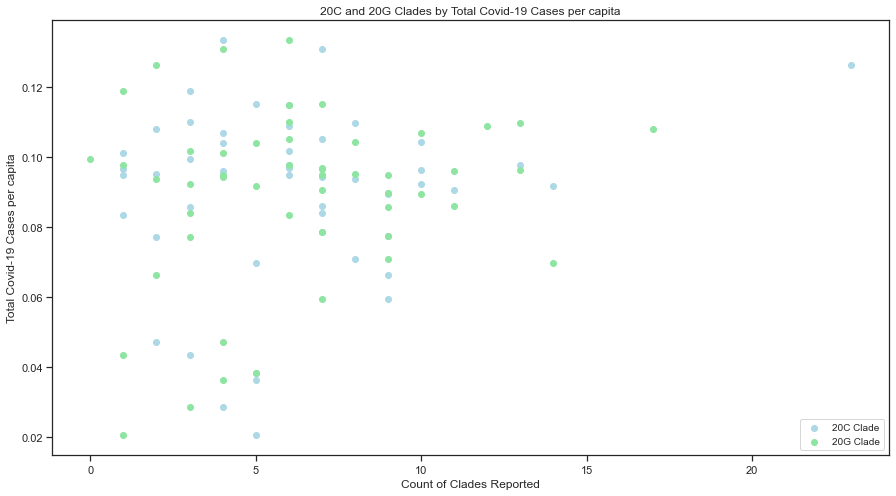

In [18]:
# scatter, pick 2 clades, by cases per cap
fig, ax = plt.subplots(1, 1, figsize=(15,8))
c = plt.scatter(totals['20C'], totals['cases_per_cap'], c='lightblue')
g = plt.scatter(totals['20G'], totals['cases_per_cap'], c='g')
plt.legend((c, g), ('20C Clade', '20G Clade'), loc = 'lower right', fontsize = 10)
plt.title('20C and 20G Clades by Total Covid-19 Cases per capita')
plt.xlabel('Count of Clades Reported')
plt.ylabel('Total Covid-19 Cases per capita')
plt.show()